In [28]:
workdir = '/SNS/users/lj7/dv/sns-chops/detcalib/ARCS/out'
!mkdir -p {workdir}
%cd {workdir}

/SNS/users/lj7/dv/sns-chops/detcalib/ARCS/out


In [16]:
import os, numpy as np

In [9]:
from mantid import simpleapi as msa

In [2]:
from mantid.geometry import CrystalStructure, ReflectionGenerator

In [19]:
from matplotlib import pyplot as plt
%matplotlib notebook

# d-spacing from lattice constants
For all of the calibrations there needs to be a "known" lattice constant to calibrate against when determining the tof to dspacing conversion factors. Traditionally at SNS diamond is used for this. Mantid has a facility for [crystal structure and reflections](http://docs.mantidproject.org/nightly/concepts/CrystalStructureAndReflections.html) built in.

Lattice constant of diamond from argonne http://7id.xray.aps.anl.gov/calculators/crystal_lattice_parameters.html

In [29]:
!wget  http://7id.xray.aps.anl.gov/calculators/crystal_lattice_parameters.html

--2018-05-11 11:19:47--  http://7id.xray.aps.anl.gov/calculators/crystal_lattice_parameters.html
Resolving 7id.xray.aps.anl.gov (7id.xray.aps.anl.gov)... 164.54.98.24
Connecting to 7id.xray.aps.anl.gov (7id.xray.aps.anl.gov)|164.54.98.24|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29013 (28K) [text/html]
Saving to: ‘crystal_lattice_parameters.html’

100%[======================================>] 29,013      --.-K/s   in 0.001s  

2018-05-11 11:19:47 (39.2 MB/s) - ‘crystal_lattice_parameters.html’ saved [29013/29013]



In [3]:
latticeConstants = ['3.56683' for i in xrange(3)] # 
Si = CrystalStructure(' '.join(latticeConstants), "F d -3 m", "C 0 0 0 1.0 0.05")
generator = ReflectionGenerator(Si)
dvalues = generator.getDValues(generator.getUniqueHKLs(.4,4.))
print dvalues

[2.05931,1.26106,1.02966,1.07544,0.818287,0.686437,0.891708,0.728076,0.630532,0.594472,0.514828,0.686437,0.602904,0.543936,0.499456,0.464362,0.411862,0.563965,0.53772,0.476638,0.432542,0.420355,0.409143,0.499456,0.464362,0.435758,0.411862,0.445854,0.420355]


In [6]:
dvalues = np.array(dvalues)
dvalues = np.array(dvalues*1e8, dtype=int)/1e8
dvalues = np.unique(dvalues)
dvalues

array([ 0.40914346,  0.41186205,  0.42035494,  0.43254167,  0.43575763,
        0.44585375,  0.46436171,  0.4766377 ,  0.4994561 ,  0.51482756,
        0.53771985,  0.54393647,  0.56396534,  0.59447166,  0.60290431,
        0.63053242,  0.68643675,  0.72807612,  0.81828692,  0.8917075 ,
        1.02965513,  1.0754397 ,  1.26106484,  2.05931026])

# Get d values from exp data

95892: diamond white beam

## Load data

In [10]:
%%time
wkspName='ARCS_95892'

msa.LoadEventAndCompress(
    Filename="ARCS_95892_event.nxs", OutputWorkspace=wkspName,
    MaxChunkSize=16, FilterBadPulses=25)
msa.CropWorkspace(InputWorkspace=wkspName, OutputWorkspace=wkspName, XMin=300, XMax=16666.7)

CPU times: user 13min 8s, sys: 7min 53s, total: 21min 1s
Wall time: 7min 11s


In [39]:
# mtd.getObjectNames()

## Convert to I(d)

In [22]:
%%time
I_d = msa.ConvertUnits(InputWorkspace=wkspName, Target='dSpacing', EMode='Elastic')

CPU times: user 13.3 s, sys: 8.59 s, total: 21.9 s
Wall time: 21.9 s


In [23]:
%%time
I_d = msa.Rebin(InputWorkspace=I_d, Params='0.3,-0.0005,3.5')

CPU times: user 78.7 ms, sys: 7.52 ms, total: 86.2 ms
Wall time: 84.6 ms


In [24]:
%%time
I_d_s = msa.SumSpectra(InputWorkspace=I_d)

CPU times: user 10.6 s, sys: 23 s, total: 33.6 s
Wall time: 33.6 s


In [43]:
# mtd.getObjectNames()

## Plot

<IPython.core.display.Javascript object>


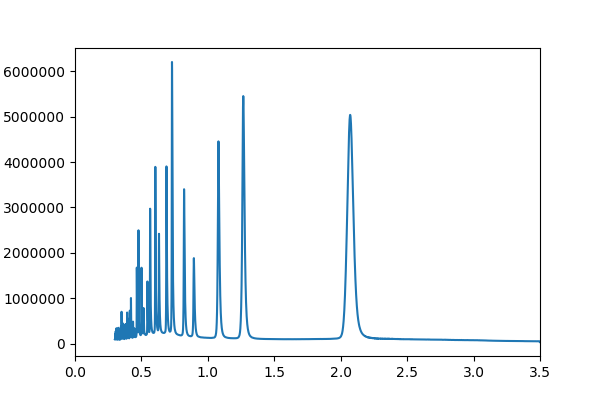

(0, 3.5)

In [25]:
plt.figure(figsize=(6,4))
plt.plot(I_d_s.readX(0)[:-1], I_d_s.readY(0))
plt.xlim(0,3.5)

In [21]:
dvalues

array([ 0.40914346,  0.41186205,  0.42035494,  0.43254167,  0.43575763,
        0.44585375,  0.46436171,  0.4766377 ,  0.4994561 ,  0.51482756,
        0.53771985,  0.54393647,  0.56396534,  0.59447166,  0.60290431,
        0.63053242,  0.68643675,  0.72807612,  0.81828692,  0.8917075 ,
        1.02965513,  1.0754397 ,  1.26106484,  2.05931026])

Compare these with the plot, we just pick the few peaks with large intensities. 

In [27]:
dvalues1 = list(dvalues[-7:])
print dvalues1

[0.72807611999999999, 0.81828692000000003, 0.89170749999999999, 1.0296551300000001, 1.0754397, 1.26106484, 2.0593102600000002]
